# Piecewise Training for Semantic Segmentation - Complete Pipeline
This notebook demonstrates:
1. Download and prepare VOC 2012 dataset
2. Install dependencies
3. Configure dataset paths
4. Visualize samples
5. Train the piecewise segmentation model
6. Generate comprehensive evaluation reports
7. Run inference on test images

## 1. Install Dependencies
Run the following cell to install required packages.

In [1]:
%pip install torch torchvision numpy pillow matplotlib tqdm pandas tabulate seaborn 

Looking in indexes: https://boartifactory.micron.com/artifactory/api/pypi/micron-pypi-rel-virtual/simple
Note: you may need to restart the kernel to use updated packages.


## 2. Download VOC 2012 Dataset
Download from [VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) and extract it.
Expected structure:
```
VOCdevkit/VOC2012/
  ├── JPEGImages/
  ├── SegmentationClass/
  ├── ImageSets/Segmentation/
```

In [2]:
import kagglehub
huanghanchina_pascal_voc_2012_path = kagglehub.dataset_download('huanghanchina/pascal-voc-2012')

print('Data source import complete.')


c:\Users\rkekanaje\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


## 3. Configure Dataset Paths
Update the paths below to point to your VOC2012 dataset.

In [3]:
import os

#huanghanchina_pascal_voc_2012_path="C:\\Users\\rkekanaje\\.cache\\kagglehub\\datasets\\huanghanchina\\pascal-voc-2012\\versions\\1"
# After kagglehub download
base_path = huanghanchina_pascal_voc_2012_path
print(f"Dataset downloaded to: {base_path}")

# Configure paths
image_dir = os.path.join(base_path,  'VOC2012', 'JPEGImages')
label_dir = os.path.join(base_path,  'VOC2012', 'SegmentationClass')
train_list = os.path.join(base_path,  'VOC2012', 'ImageSets', 'Segmentation', 'train.txt')
val_list = os.path.join(base_path,  'VOC2012', 'ImageSets', 'Segmentation', 'val.txt')

# Verify paths exist
assert os.path.exists(image_dir), f"Image directory not found: {image_dir}"
assert os.path.exists(label_dir), f"Label directory not found: {label_dir}"
print(f"✅ Image directory: {image_dir}")
print(f"✅ Label directory: {label_dir}")

# Check dataset statistics
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]
print(f"\n📊 Dataset Statistics:")
print(f"   Total images: {len(image_files)}")
print(f"   Labeled images: {len(label_files)}")

Dataset downloaded to: C:\Users\rkekanaje\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1
✅ Image directory: C:\Users\rkekanaje\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1\VOC2012\JPEGImages
✅ Label directory: C:\Users\rkekanaje\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1\VOC2012\SegmentationClass

📊 Dataset Statistics:
   Total images: 17125
   Labeled images: 2913


In [4]:
# Device configuration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ✅ RESTART KERNEL FIRST!

print("\n" + "="*70)
print("TESTING FIXED CRF IMPLEMENTATION")
print("="*70)

import torch
from src.piecewise_training.model import DenseCRF

# Test with different batch sizes
test_cases = [
    (1, 21, 64, 64),   # Single image
    (4, 21, 64, 64),   # Small batch
    (8, 21, 64, 64),   # Training batch size
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

crf = DenseCRF(num_classes=21, num_iterations=5).to(device)

for batch_size, num_classes, h, w in test_cases:
    print(f"\nTesting: batch_size={batch_size}, classes={num_classes}, size={h}x{w}")
    
    unary = torch.randn(batch_size, num_classes, h, w).to(device)
    image = torch.randn(batch_size, 3, h, w).to(device)
    
    try:
        output = crf(unary, image)
        assert output.shape == unary.shape, f"Shape mismatch! Expected {unary.shape}, got {output.shape}"
        assert torch.allclose(output.sum(dim=1), torch.ones(batch_size, h, w).to(device), atol=1e-5), "Not a valid probability distribution!"
        print(f"   ✅ PASSED - Output shape: {output.shape}")
    except Exception as e:
        print(f"   ❌ FAILED - Error: {e}")
        raise

print("\n" + "="*70)
print("✅ ALL CRF TESTS PASSED!")
print("="*70)


TESTING FIXED CRF IMPLEMENTATION
Using device: cuda


Testing: batch_size=1, classes=21, size=64x64
   ✅ PASSED - Output shape: torch.Size([1, 21, 64, 64])

Testing: batch_size=4, classes=21, size=64x64
   ✅ PASSED - Output shape: torch.Size([4, 21, 64, 64])

Testing: batch_size=8, classes=21, size=64x64
   ✅ PASSED - Output shape: torch.Size([8, 21, 64, 64])

✅ ALL CRF TESTS PASSED!


In [6]:
# Pascal VOC class names
PASCAL_VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
    'sofa', 'train', 'tvmonitor'
]

# Device configuration

## 4. Visualize a Sample Image and Label

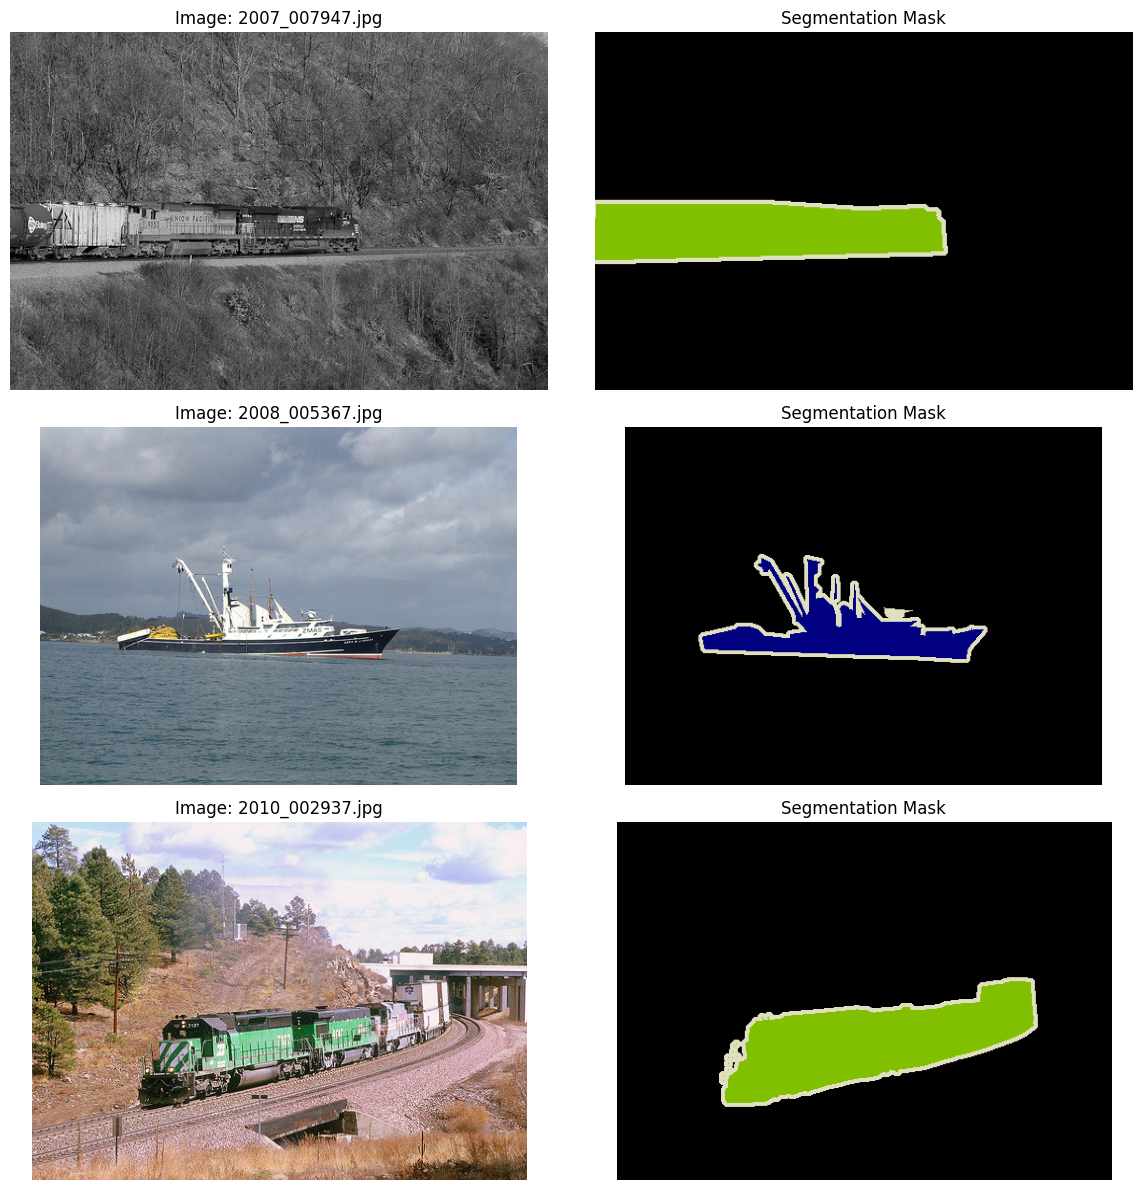

✅ Visualized 3 samples


In [7]:

from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import os

def visualize_voc_samples(num_samples=3):
    """Visualize random samples from VOC dataset."""
    
    # Check if directories exist
    if not os.path.exists(image_dir):
        print(f"❌ Error: Image directory not found: {image_dir}")
        return
    
    if not os.path.exists(label_dir):
        print(f"❌ Error: Label directory not found: {label_dir}")
        return
    
    # Get list of LABEL files (these are the images with annotations)
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]
    
    if len(label_files) == 0:
        print(f"❌ Error: No label files found in {label_dir}")
        return
    
    # Sample random files
    sample_files = random.sample(label_files, min(num_samples, len(label_files)))
    
    # Create color map for visualization
    def create_pascal_label_colormap():
        """Creates a label colormap used in PASCAL VOC segmentation benchmark."""
        colormap = np.zeros((256, 3), dtype=np.uint8)
        
        def bit_get(val, idx):
            return (val >> idx) & 1
        
        for i in range(256):
            r = g = b = 0
            c = i
            for j in range(8):
                r |= bit_get(c, 0) << (7 - j)
                g |= bit_get(c, 1) << (7 - j)
                b |= bit_get(c, 2) << (7 - j)
                c >>= 3
            
            colormap[i] = [r, g, b]
        
        return colormap
    
    colormap = create_pascal_label_colormap()
    
    # Visualize
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, label_file in enumerate(sample_files):
        # Load image
        image_file = label_file.replace('.png', '.jpg')
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, label_file)
        
        if not os.path.exists(image_path):
            print(f"⚠️  Warning: Image not found: {image_path}")
            continue
        
        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path)
        
        # Convert label to colored version
        label_array = np.array(label)
        colored_label = colormap[label_array]
        
        # Plot
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title(f'Image: {image_file}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(colored_label)
        axes[idx, 1].set_title(f'Segmentation Mask')
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualized {len(sample_files)} samples")

# Call the function
visualize_voc_samples(num_samples=3)

## 5. Train the Piecewise Model
This uses the implementation from `Efficient Piecewise Training of Deep Structured Models for Semantic Segmentation` (model, trainer, dataset classes).

In [8]:
# Import required modules
from src.piecewise_training.model import PiecewiseTrainedModel
from src.piecewise_training.trainer import PiecewiseTrainer
from src.piecewise_training.dataset import SegmentationDataset, RandomHorizontalFlip
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from tqdm import tqdm

# Configuration
num_classes = 21
batch_size = 8
num_workers = 4 if torch.cuda.is_available() else 0  

print("Creating datasets...")

# Create full dataset
full_dataset = SegmentationDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=RandomHorizontalFlip(p=0.5),  
    image_size=(512, 512)
)

print(f"Total dataset size: {len(full_dataset)}")

# Split 80/20 for train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,  
    pin_memory=True if torch.cuda.is_available() else False  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Training batches: {len(train_loader)}")
print(f"✅ Validation batches: {len(val_loader)}")


print("\n" + "="*70)
print("COMPUTING CLASS WEIGHTS (CRITICAL!)")
print("="*70)

# Compute class frequencies
class_counts = torch.zeros(num_classes, dtype=torch.float32)
total_pixels = 0

print("Scanning training dataset...")
for _, labels in tqdm(train_loader, desc="Computing class weights"):
    valid_mask = labels != 255
    for cls in range(num_classes):
        class_counts[cls] += ((labels == cls) & valid_mask).sum().item()
    total_pixels += valid_mask.sum().item()

# Compute inverse frequency weights
class_freq = class_counts / total_pixels
class_weights = 1.0 / (class_freq + 1e-6)

# ✅ Apply square root to reduce extremeness
class_weights = torch.sqrt(class_weights)

# ✅ Normalize so mean weight = 1.0
class_weights = class_weights / class_weights.mean()

# ✅ Cap maximum weight
class_weights = torch.clamp(class_weights, min=0.1, max=10.0)

# Move to device
class_weights = class_weights.to(device)

print("\n📊 Class Distribution & Weights:")
for cls in range(num_classes):
    freq = class_freq[cls].item()
    weight = class_weights[cls].item()
    count = int(class_counts[cls].item())
    print(f"   {PASCAL_VOC_CLASSES[cls]:15s}: "
          f"count={count:8d}, freq={freq:6.2%}, weight={weight:6.4f}")

print(f"\n✅ Class weights computed!")
print(f"   Min weight: {class_weights.min().item():.4f}")
print(f"   Max weight: {class_weights.max().item():.4f}")
print(f"   Mean weight: {class_weights.mean().item():.4f}")
print("="*70)

# print("\n" + "="*70)
# print("COMPUTING CLASS WEIGHTS FOR BALANCED TRAINING")
# print("="*70)

# # Scan training set
# class_counts = torch.zeros(num_classes)
# total_pixels = 0

# print("Scanning training set to compute class frequencies...")
# for images, labels in tqdm(train_loader, desc="Computing class weights"):
#     valid_mask = labels != 255
#     for cls in range(num_classes):
#         class_counts[cls] += ((labels == cls) & valid_mask).sum().item()
#     total_pixels += valid_mask.sum().item()

# # ✅ CHANGE: Use SQRT of inverse frequency (less extreme)
# class_freq = class_counts / total_pixels
# class_weights = 1.0 / (class_freq + 1e-6)

# # ✅ CRITICAL: Apply square root to reduce extremeness
# class_weights = torch.sqrt(class_weights)

# # ✅ Normalize so mean weight = 1.0
# class_weights = class_weights / class_weights.mean()

# # ✅ Cap maximum weight to prevent extreme values
# max_weight = 10.0
# class_weights = torch.clamp(class_weights, min=0.1, max=max_weight)

# class_weights = class_weights.to(device)

# print("\n📊 Class Weights (SQRT-balanced):")
# for cls in range(num_classes):
#     count = int(class_counts[cls].item())
#     weight = class_weights[cls].item()
#     print(f"   Class {cls:2d} ({PASCAL_VOC_CLASSES[cls]:15s}): "
#           f"count={count:9d}, weight={weight:6.4f}")

# print("\n✅ Class weights computed!")
# print(f"   Min weight: {class_weights.min().item():.4f}")
# print(f"   Max weight: {class_weights.max().item():.4f}")
# print(f"   Mean weight: {class_weights.mean().item():.4f}")
# print("="*70)

# Test dataset loading
print("\nTesting dataset loading...")
img, label = full_dataset[0]
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")
print(f"Label unique values: {torch.unique(label)}")
print(f"Image range: [{img.min():.3f}, {img.max():.3f}]")
print("✅ Dataset loading test passed!")

print("\nCreating model and trainer...")


# Delete old model to free memory
if 'model' in locals():
    del model
    torch.cuda.empty_cache()
    print("✅ Cleared old model from memory")

model = PiecewiseTrainedModel(
    num_classes=num_classes,
    crf_iterations=5,
    use_crf=True,
    pretrained=True
)
# # ✅ Apply custom initialization to classifier
# def init_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

# def init_weights_strong(m):
#     """Initialize with stronger random weights."""
#     if isinstance(m, nn.Conv2d):
#         # Use larger std for initial weights
#         nn.init.normal_(m.weight, mean=0, std=0.02)  # ✅ Increased from 0.01
#         if m.bias is not None:
#             # Initialize biases to small negative values to prevent saturation
#             nn.init.constant_(m.bias, -0.01)  # ✅ Small negative bias
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

# # Initialize classifier layers (not VGG backbone)
# model.unary_net.classifier.apply(init_weights_strong)
# #print("✅ Applied Kaiming initialization to classifier")

model=model.to(device)

# Test model initialization
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    unary_output, _ = model(images, apply_crf=False)
    preds = unary_output.argmax(1)
    unique_preds = sorted(preds.unique().cpu().tolist())
    
    print(f"\n📊 Initial predictions: {unique_preds}")
    print(f"   Number of unique classes: {len(unique_preds)}")
    
    if len(unique_preds) < 3:
        print(f"   ⚠️  WARNING: Only {len(unique_preds)} classes predicted!")
        print(f"   Trying even stronger initialization...")
        
        # Even stronger
        for m in model.unary_net.classifier.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.05)  # ✅ Much larger std
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)  # ✅ Random biases
        
        # Test again
        with torch.no_grad():
            unary_output, _ = model(images, apply_crf=False)
            preds = unary_output.argmax(1)
            unique_preds = sorted(preds.unique().cpu().tolist())
            print(f"   After stronger init: {unique_preds} ({len(unique_preds)} classes)")

print("="*70)


Creating datasets...
Loaded 2913 images with segmentation labels
Total dataset size: 2913
Training samples: 2330
Validation samples: 583
✅ Training batches: 292
✅ Validation batches: 73

COMPUTING CLASS WEIGHTS (CRITICAL!)
Scanning training dataset...


Computing class weights: 100%|██████████| 292/292 [00:29<00:00, 10.02it/s]
c:\Users\rkekanaje\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rkekanaje\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



📊 Class Distribution & Weights:
   background     : count=423531072, freq=73.40%, weight=0.1231
   aeroplane      : count= 4579393, freq= 0.79%, weight=1.1836
   bicycle        : count= 1873253, freq= 0.32%, weight=1.8504
   bird           : count= 4574731, freq= 0.79%, weight=1.1842
   boat           : count= 3431870, freq= 0.59%, weight=1.3672
   bottle         : count= 3996113, freq= 0.69%, weight=1.2670
   bus            : count=11417987, freq= 1.98%, weight=0.7496
   car            : count= 8463760, freq= 1.47%, weight=0.8706
   cat            : count=14323118, freq= 2.48%, weight=0.6693
   chair          : count= 5447786, freq= 0.94%, weight=1.0852
   cow            : count= 6215637, freq= 1.08%, weight=1.0160
   diningtable    : count= 6241135, freq= 1.08%, weight=1.0139
   dog            : count=10952283, freq= 1.90%, weight=0.7654
   horse          : count= 5933081, freq= 1.03%, weight=1.0399
   motorbike      : count= 6544586, freq= 1.13%, weight=0.9901
   person         : c

In [9]:
trainer = PiecewiseTrainer(
    model=model,
    device=device,
    num_classes=num_classes,
    learning_rate=1e-3,
    weight_decay=5e-4,
    class_weights=class_weights
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


✅ Using class weights (min=0.1231, max=1.8504)
✅ Model created!
   Total parameters: 134,346,586
   Trainable parameters: 134,346,586


## 6. Train the Piecewise Model

In [ ]:
import pickle
from pathlib import Path

print("\n" + "="*70)
print("STARTING PIECEWISE TRAINING (WITH AUTO-SAVE)")
print("="*70)

# Create results directory
results_dir = Path('training_results')
results_dir.mkdir(parents=True, exist_ok=True)

# ✅ OPTION 1: Train all stages with auto-save
try:
    history = trainer.train_piecewise(
        train_loader=train_loader,
        stage1_epochs=20,
        stage2_epochs=5,
        stage3_epochs=10,
        val_loader=val_loader
    )
    
    # Save complete history
    with open(results_dir / 'training_history_complete.pkl', 'wb') as f:
        pickle.dump(history, f)
    print(f"\n✅ Complete history saved!")
    
except Exception as e:
    print(f"\n❌ Training crashed: {e}")
    print("   Partial results may be saved in individual stage files")

# Save model
model_save_path = results_dir / 'piecewise_model_final.pth'
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved to: {model_save_path}")


STARTING PIECEWISE TRAINING (WITH AUTO-SAVE)
Stage 1: Training Unary Network (Following CVPR 2016 Paper)
   Base LR: 0.001
   Optimizer: SGD with momentum 0.9
   LR Schedule: Poly (power=0.9)
   Epochs: 2

   Total iterations: 584
   Iterations per epoch: 292



Epoch 1/2: 100%|██████████| 292/292 [09:52<00:00,  2.03s/it, loss=3.1403, lr=0.000589]


Epoch 1/2: Train Loss=2.8276 | Val Loss=2.7153 | Val mIoU=0.0348 | Val Acc=0.7318 | LR=0.000589



Epoch 2/2: 100%|██████████| 292/292 [09:52<00:00,  2.03s/it, loss=2.4271, lr=0.000001]


Epoch 2/2: Train Loss=2.7244 | Val Loss=2.6975 | Val mIoU=0.0348 | Val Acc=0.7318 | LR=0.000001

Stage 1 Complete! Best Val mIoU: 0.0348


Stage 2: Training CRF Parameters with Piecewise Loss


Epoch 1/2: 100%|██████████| 292/292 [02:37<00:00,  1.86it/s, loss=3.0468, lr=0.000059]


Epoch 1/2: Train Loss=3.0517 | Val Loss=3.0491 | Val mIoU=0.0095 | Val Acc=0.0820 | LR=0.000059



Epoch 2/2: 100%|██████████| 292/292 [02:36<00:00,  1.87it/s, loss=3.0571, lr=0.000000]


Epoch 2/2: Train Loss=3.0518 | Val Loss=3.0490 | Val mIoU=0.0091 | Val Acc=0.0816 | LR=0.000000

Stage 2 Complete! Best Val mIoU: 0.0095

Stage 3: Joint Fine-tuning (Following CVPR 2016 Paper)
   Base LR: 1e-05
   Optimizer: SGD with momentum 0.9
   LR Schedule: Poly (power=0.9)
   Total iterations: 584



Epoch 1/2: 100%|██████████| 292/292 [24:51<00:00,  5.11s/it, loss=3.0558, lr=0.000005]


Epoch 1/2: Loss=3.0515 | Val Loss=3.0489 | Val mIoU=0.0088 | Val Acc=0.0826 | LR=0.000005



Epoch 2/2: 100%|██████████| 292/292 [24:37<00:00,  5.06s/it, loss=3.0507, lr=0.000000]


Epoch 2/2: Loss=3.0515 | Val Loss=3.0488 | Val mIoU=0.0088 | Val Acc=0.0835 | LR=0.000000

Stage 3 Complete! Best Val mIoU: 0.0088


✅ Complete history saved!
✅ Model saved to: training_results\piecewise_model_final.pth


## 7. Generate Comprehensive Evaluation Report

In [11]:
from pathlib import Path

print("\n" + "="*70)
print("GENERATING COMPREHENSIVE EVALUATION REPORT")
print("="*70)

from src.piecewise_training.visualization import ComprehensiveVisualizer
import numpy as np

# Create visualizer
visualizer = ComprehensiveVisualizer(
    num_classes=num_classes,
    class_names=PASCAL_VOC_CLASSES
)

# Collect validation metrics
print("\n📊 Collecting validation metrics...")
model.eval()

confusion_matrix = np.zeros((num_classes, num_classes))
sample_predictions = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Get predictions
        unary_output, crf_output = model(images, apply_crf=True)
        unary_pred = unary_output.argmax(1)
        crf_pred = crf_output.argmax(1) if crf_output is not None else unary_pred
        
        # Update confusion matrix
        for i in range(num_classes):
            for j in range(num_classes):
                mask = labels != 255  # Ignore index
                confusion_matrix[i, j] += (
                    (labels[mask] == i) & (crf_pred[mask] == j)
                ).sum().item()
        
        # Collect sample predictions (first 10 batches)
        if batch_idx < 10:
            for b in range(min(3, images.shape[0])):
                sample_predictions.append({
                    'image': images[b].cpu(),      
                    'gt': labels[b].cpu(),
                    'unary_pred': unary_pred[b].cpu(),
                    'crf_pred': crf_pred[b].cpu(),    
                    'pred': crf_pred[b].cpu()           
                })
        
        if batch_idx % 10 == 0:
            print(f"   Processed {batch_idx}/{len(val_loader)} batches...")

# Compute final metrics
print("\n📈 Computing final metrics...")
iou_per_class = visualizer._compute_iou_from_cm(confusion_matrix)
mean_iou = np.nanmean(iou_per_class)

final_metrics = {
    'mIoU': mean_iou,
    'Pixel Acc': confusion_matrix.diagonal().sum() / confusion_matrix.sum()
}

print(f"\n✅ Final mIoU: {mean_iou:.4f}")
print(f"✅ Pixel Accuracy: {final_metrics['Pixel Acc']:.4f}")

# Generate complete report
print("\n🎨 Generating visualizations...")
results_dir = 'training_results'
Path(results_dir).mkdir(parents=True, exist_ok=True)

visualizer.generate_full_report(
    history=history,
    final_metrics=final_metrics,
    confusion_matrix=confusion_matrix,
    sample_predictions=sample_predictions,
    save_dir=results_dir
)

print(f"\n✅ Complete report saved to: {results_dir}/")


GENERATING COMPREHENSIVE EVALUATION REPORT

📊 Collecting validation metrics...
   Processed 0/73 batches...
   Processed 10/73 batches...
   Processed 20/73 batches...
   Processed 30/73 batches...
   Processed 40/73 batches...
   Processed 50/73 batches...
   Processed 60/73 batches...
   Processed 70/73 batches...

📈 Computing final metrics...

✅ Final mIoU: 0.0090
✅ Pixel Accuracy: 0.0841

🎨 Generating visualizations...

GENERATING COMPREHENSIVE TRAINING REPORT
📊 Plotting training curves...
   Saved to: training_results\training_curves.png
📋 Generating metrics table...

TRAINING METRICS SUMMARY
+------------+--------------+------------+------------+-----------+----------+-------------+
| Stage      |   Train Loss |   Val Loss |   Val mIoU |   Val Acc |     mIoU |   Pixel Acc |
+============+==============+============+============+===========+==========+=============+
| Stage 1    |       2.7244 |     2.6975 |     0.0348 |    0.7318 | nan      |    nan      |
+------------+--------

## 8. Display Individual Visualizations in Notebook


📊 Training Curves:


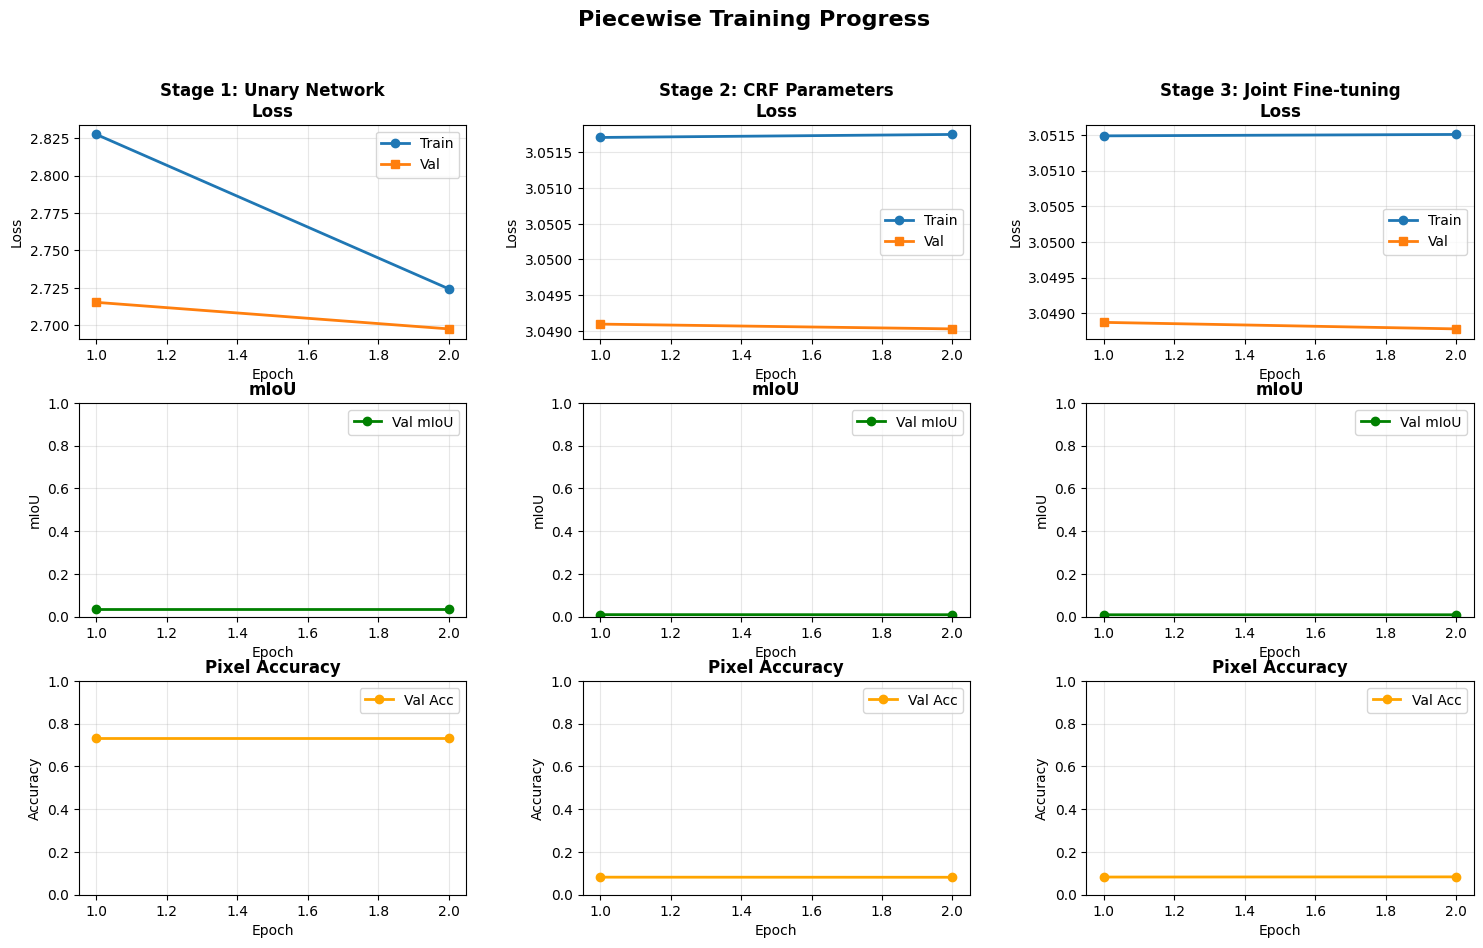


📋 Metrics Summary:

TRAINING METRICS SUMMARY
+------------+--------------+------------+------------+-----------+----------+-------------+
| Stage      |   Train Loss |   Val Loss |   Val mIoU |   Val Acc |     mIoU |   Pixel Acc |
+============+==============+============+============+===========+==========+=============+
| Stage 1    |       2.7244 |     2.6975 |     0.0348 |    0.7318 | nan      |    nan      |
+------------+--------------+------------+------------+-----------+----------+-------------+
| Stage 2    |       3.0518 |     3.0490 |     0.0091 |    0.0816 | nan      |    nan      |
+------------+--------------+------------+------------+-----------+----------+-------------+
| Stage 3    |       3.0515 |     3.0488 |     0.0088 |    0.0835 | nan      |    nan      |
+------------+--------------+------------+------------+-----------+----------+-------------+
| Final Test |     nan      |   nan      |   nan      |  nan      |   0.0090 |      0.0841 |
+------------+----------

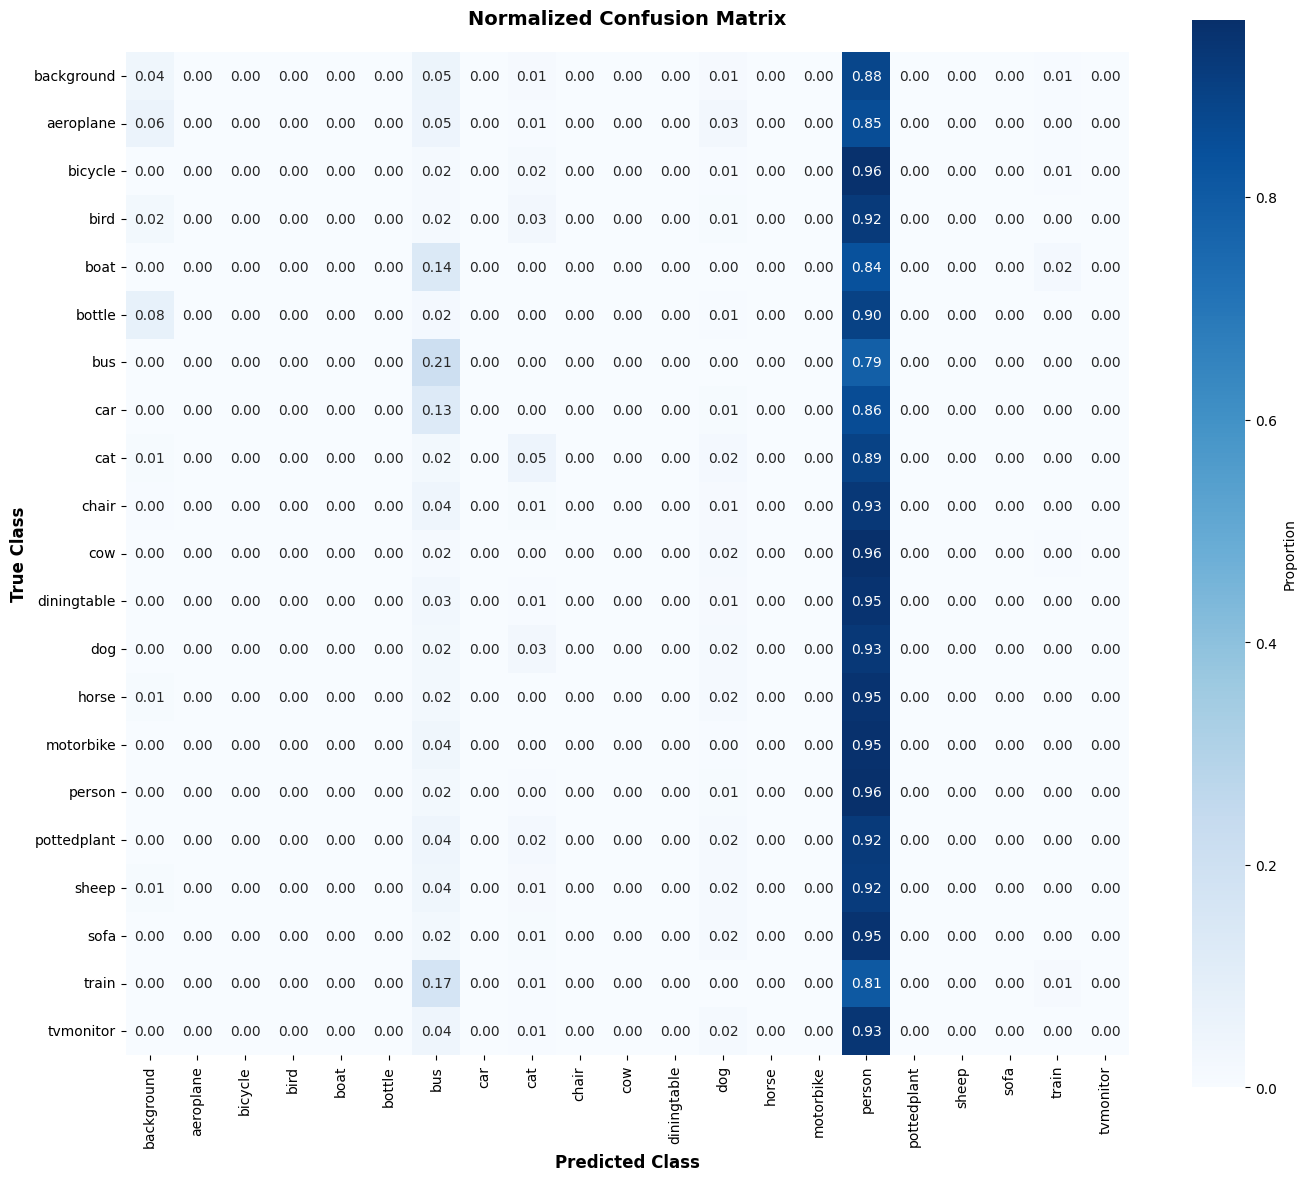


📊 Per-Class IoU:


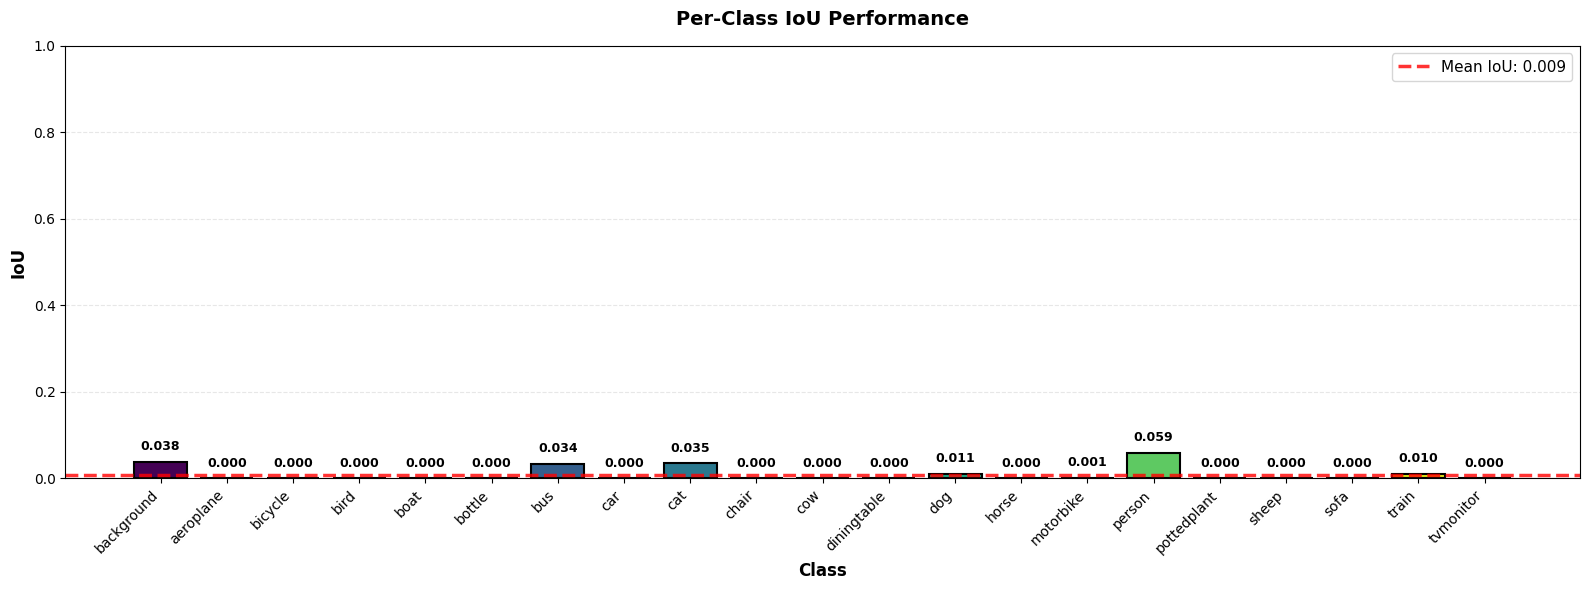


🖼️ Sample Predictions:


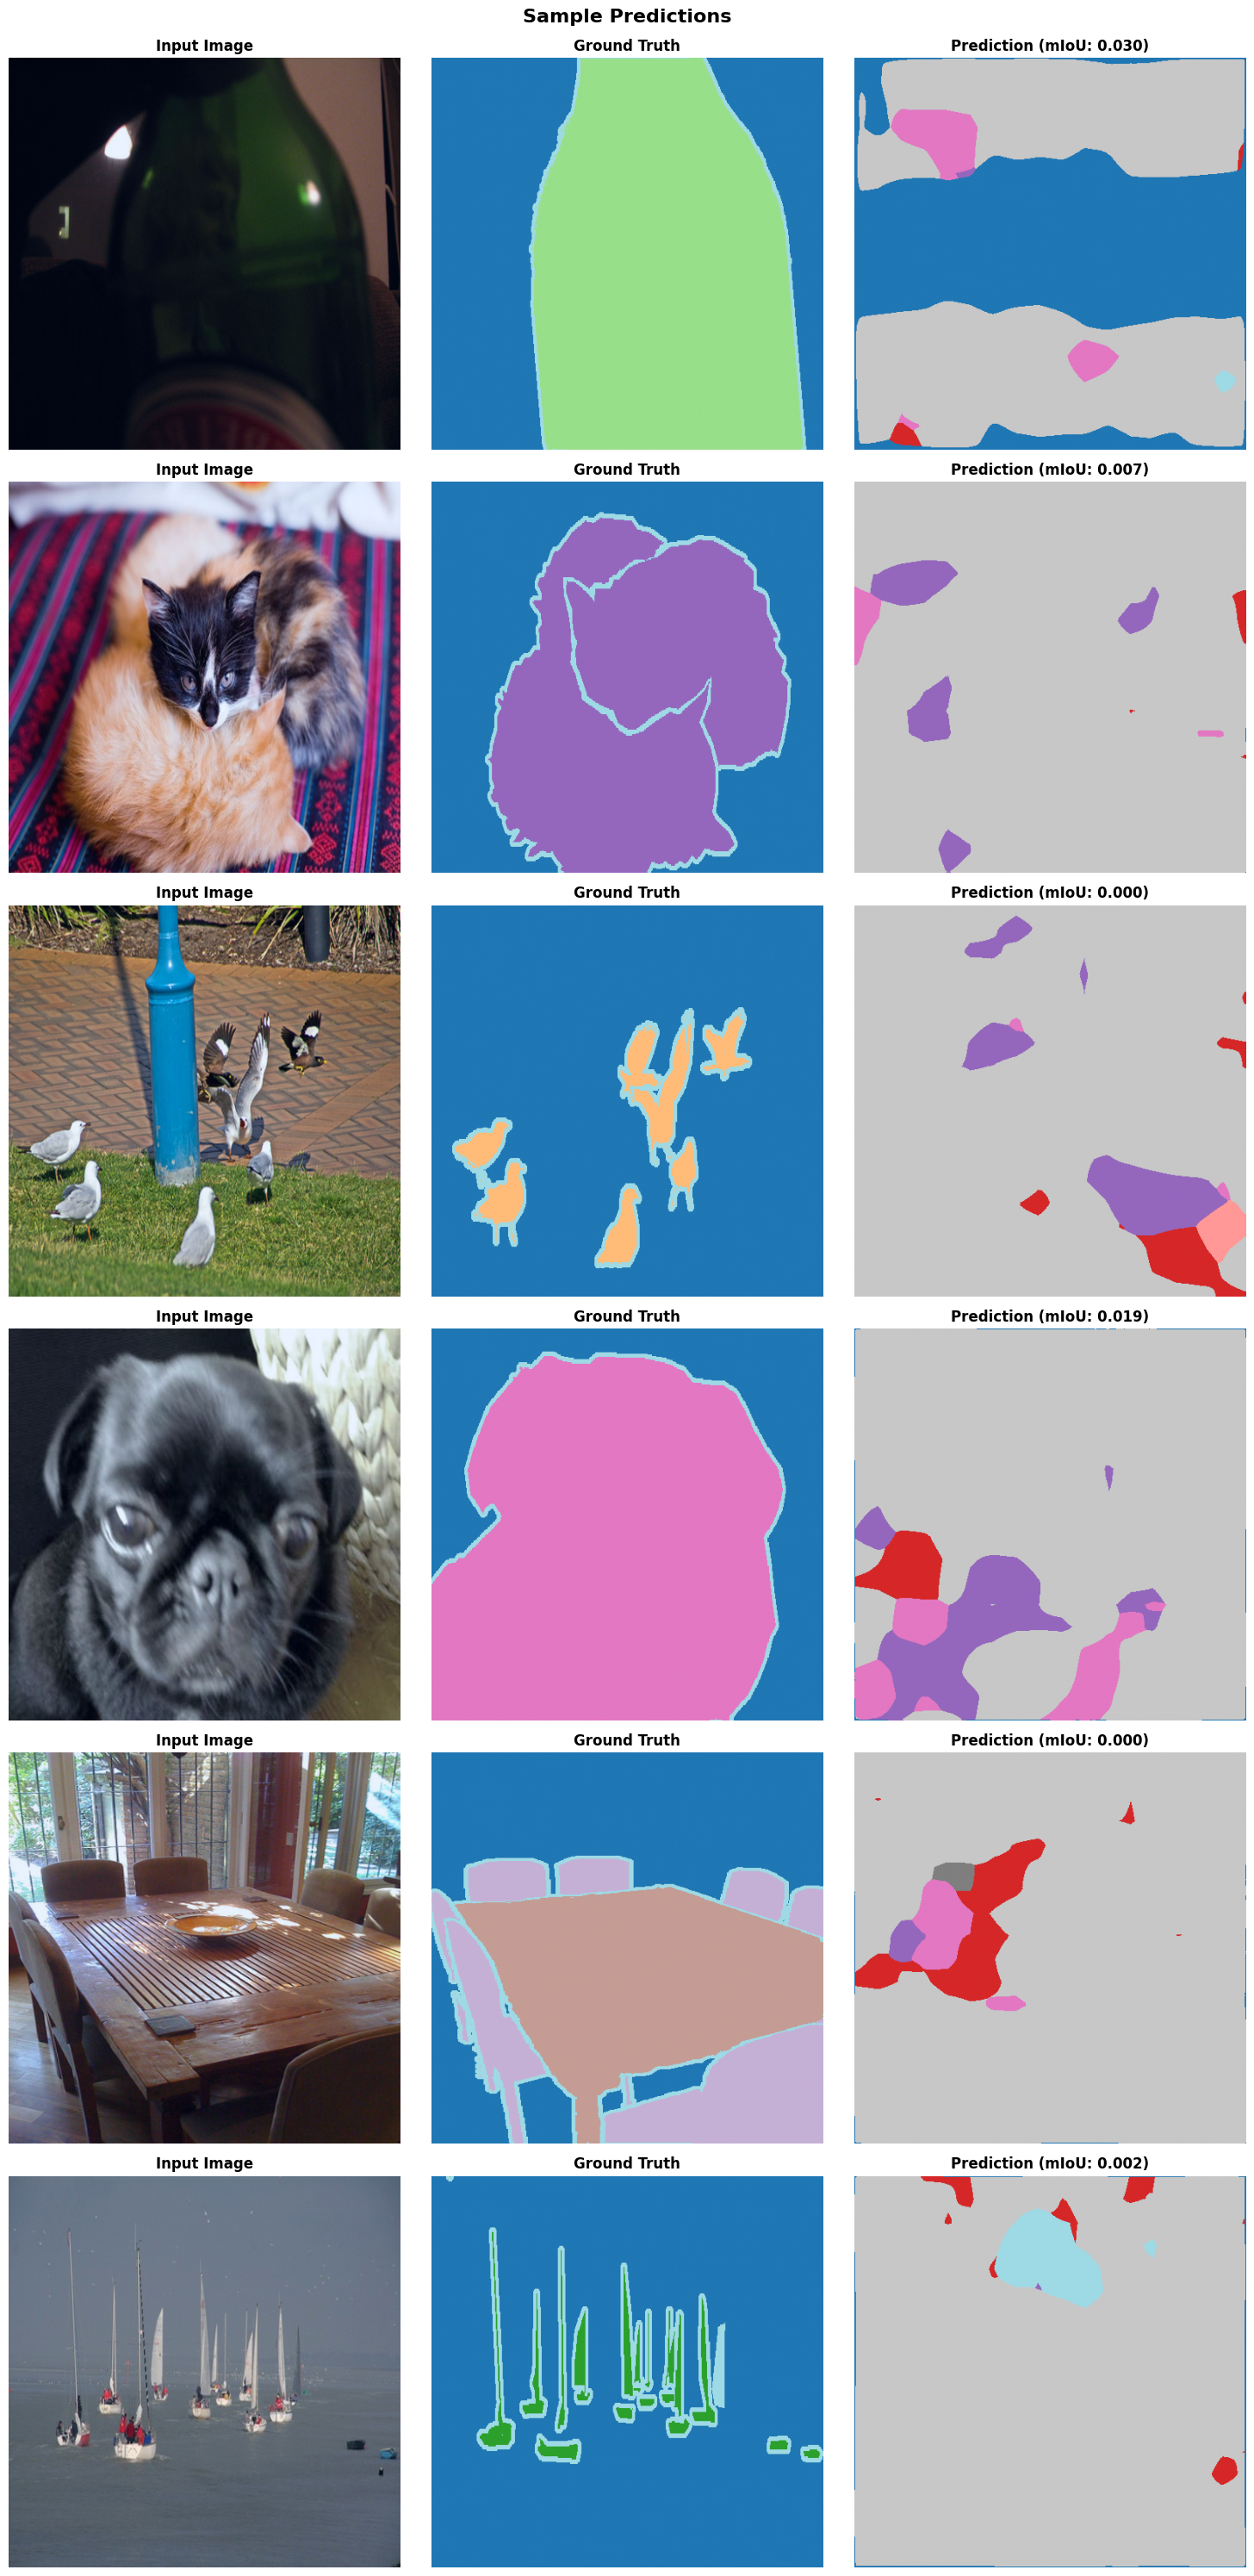


🔍 CRF Refinement Comparison:


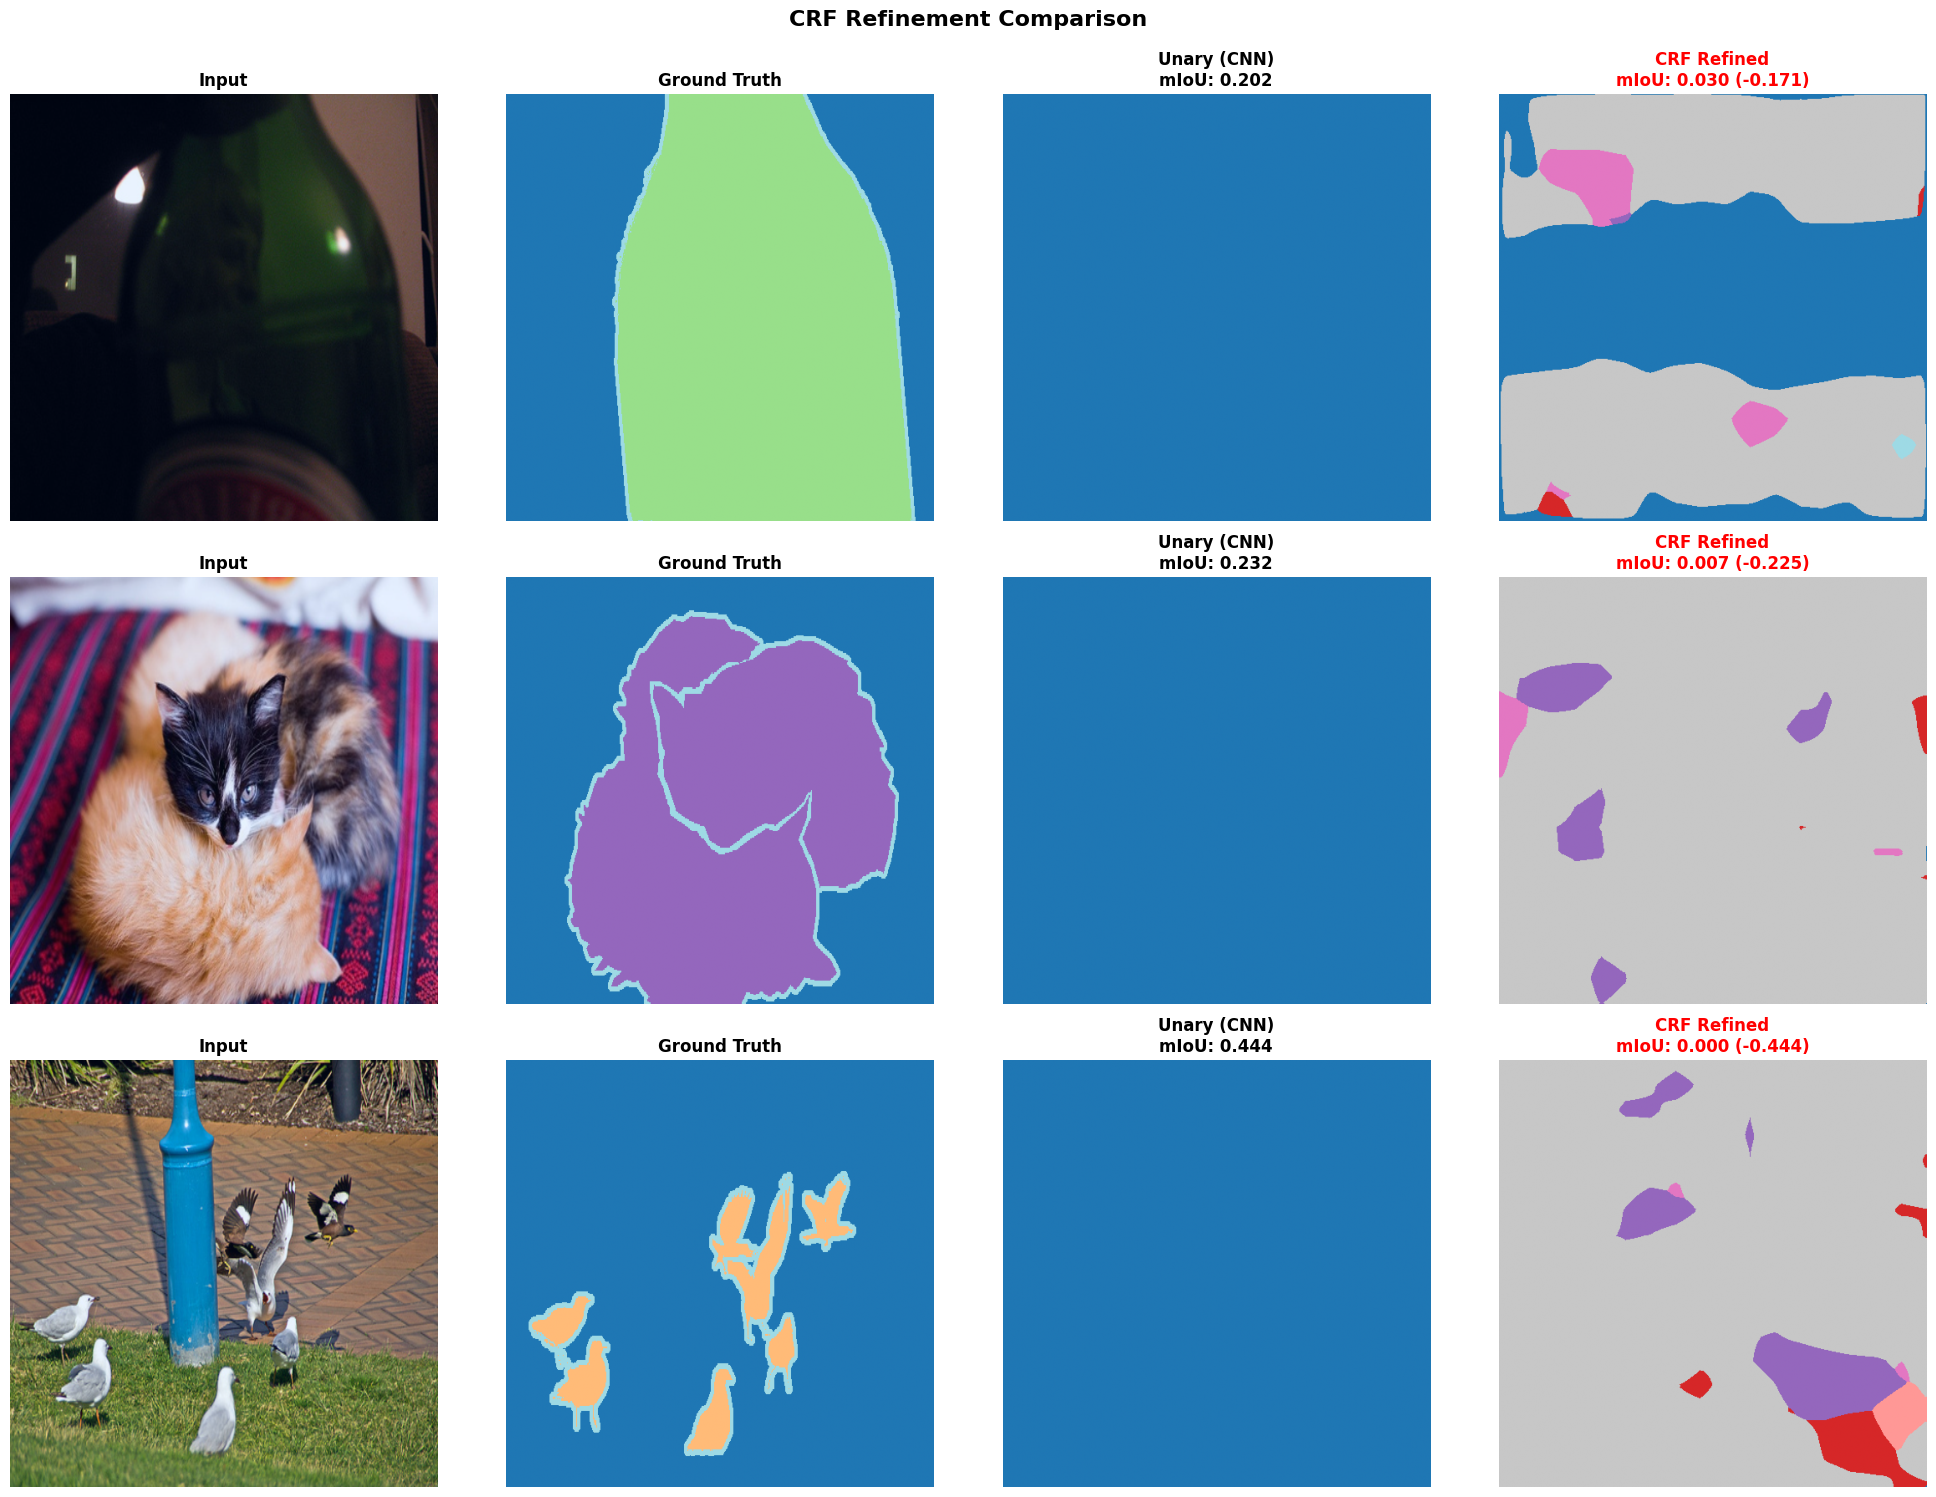

In [12]:
# 8.1 Training Curves
print("\n📊 Training Curves:")
visualizer.plot_training_curves(history)

# 8.2 Metrics Table
print("\n📋 Metrics Summary:")
visualizer.generate_metrics_table(history, final_metrics)

# 8.3 Confusion Matrix
print("\n🔢 Confusion Matrix:")
visualizer.plot_confusion_matrix(confusion_matrix)

# 8.4 Per-Class IoU
print("\n📊 Per-Class IoU:")
visualizer.plot_per_class_iou(iou_per_class)

# 8.5 Sample Predictions
print("\n🖼️ Sample Predictions:")
visualizer.visualize_predictions_grid(sample_predictions[:6])

# 8.6 CRF Comparison
print("\n🔍 CRF Refinement Comparison:")
visualizer.plot_crf_comparison(sample_predictions[:3])

## 9. Detailed Per-Class Performance Analysis

In [13]:
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*70)

# Create detailed table
import pandas as pd
from tabulate import tabulate

class_performance = []
for idx, class_name in enumerate(PASCAL_VOC_CLASSES):
    if not np.isnan(iou_per_class[idx]):
        tp = confusion_matrix[idx, idx]
        fp = confusion_matrix[:, idx].sum() - tp
        fn = confusion_matrix[idx, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_performance.append({
            'Class': class_name,
            'IoU': iou_per_class[idx],
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': int(tp + fn)
        })

df_performance = pd.DataFrame(class_performance)
df_performance = df_performance.sort_values('IoU', ascending=False)

print(tabulate(df_performance, headers='keys', tablefmt='grid', floatfmt='.4f', showindex=False))

# Save to CSV
df_performance.to_csv(f'{results_dir}/per_class_performance.csv', index=False)
print(f"\n✅ Saved to: {results_dir}/per_class_performance.csv")


PER-CLASS PERFORMANCE ANALYSIS
+-------------+--------+-------------+----------+------------+-----------+
| Class       |    IoU |   Precision |   Recall |   F1-Score |   Support |
+=============+========+=============+==========+============+===========+
| person      | 0.0589 |      0.0591 |   0.9593 |     0.1113 |   7909335 |
+-------------+--------+-------------+----------+------------+-----------+
| background  | 0.0378 |      0.9310 |   0.0379 |     0.0728 | 105834356 |
+-------------+--------+-------------+----------+------------+-----------+
| cat         | 0.0353 |      0.1022 |   0.0511 |     0.0681 |   3664341 |
+-------------+--------+-------------+----------+------------+-----------+
| bus         | 0.0344 |      0.0396 |   0.2075 |     0.0665 |   1437739 |
+-------------+--------+-------------+----------+------------+-----------+
| dog         | 0.0112 |      0.0277 |   0.0184 |     0.0221 |   2605294 |
+-------------+--------+-------------+----------+------------+------

## 10. Run Inference on Test Images


RUNNING INFERENCE ON TEST IMAGES

🖼️ Running inference on: 2010_002336.jpg


C:\Users\rkekanaje\AppData\Local\Temp\ipykernel_31596\1268625827.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


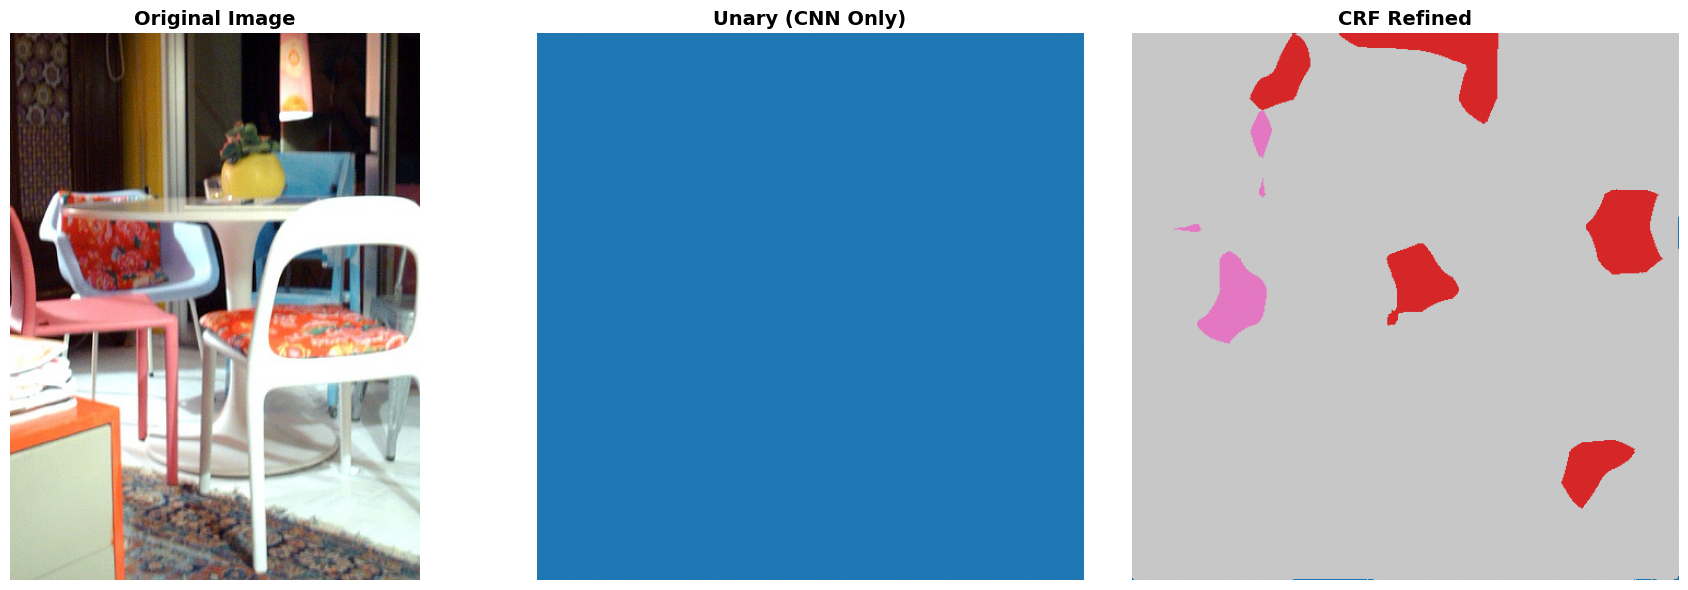

✅ Inference complete!


In [14]:
print("\n" + "="*70)
print("RUNNING INFERENCE ON TEST IMAGES")
print("="*70)

def run_inference_on_image(image_path, model, device, visualize=True):
    """Run inference on a single image."""
    from torchvision import transforms
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Resize and normalize
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Run inference
    model.eval()
    with torch.no_grad():
        unary_output, crf_output = model(image_tensor, apply_crf=True)
        
        unary_pred = unary_output.argmax(1).squeeze(0)
        crf_pred = crf_output.argmax(1).squeeze(0) if crf_output is not None else unary_pred
    
    if visualize:
        # Visualize results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Unary prediction
        colors = plt.cm.get_cmap('tab20', num_classes)
        unary_colored = colors(unary_pred.cpu().numpy())[:, :, :3]
        axes[1].imshow(unary_colored)
        axes[1].set_title('Unary (CNN Only)', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # CRF prediction
        crf_colored = colors(crf_pred.cpu().numpy())[:, :, :3]
        axes[2].imshow(crf_colored)
        axes[2].set_title('CRF Refined', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return unary_pred, crf_pred


# Example: Run inference on a random validation image
sample_label_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]
if len(sample_label_files) > 0:
    test_label = random.choice(sample_label_files)
    test_image_name = test_label.replace('.png', '.jpg')
    test_image_path = os.path.join(image_dir, test_image_name)
    
    if os.path.exists(test_image_path):
        print(f"\n🖼️ Running inference on: {test_image_name}")
        unary_pred, crf_pred = run_inference_on_image(test_image_path, model, device)
        print("✅ Inference complete!")

## 11. Batch Inference on Multiple Images

In [15]:

def batch_inference(image_paths, model, device, save_dir='inference_results'):
    """Run inference on multiple images and save results."""
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    for idx, img_path in enumerate(image_paths):
        print(f"\nProcessing {idx+1}/{len(image_paths)}: {img_path}")
        
        unary_pred, crf_pred = run_inference_on_image(
            img_path, model, device, visualize=False
        )
        
        # Save predictions
        save_path = Path(save_dir) / f"prediction_{idx:03d}.png"
        
        # Convert to color image
        colors = plt.cm.get_cmap('tab20', num_classes)
        crf_colored = (colors(crf_pred.cpu().numpy())[:, :, :3] * 255).astype(np.uint8)
        Image.fromarray(crf_colored).save(save_path)
        
        print(f"   Saved to: {save_path}")

# Example: Process multiple test images
test_images = [
    '/path/to/test/image1.jpg',
    '/path/to/test/image2.jpg',
    '/path/to/test/image3.jpg',
]

# Uncomment to run batch inference
# batch_inference(test_images, model, device)

## 12. Summary and Next Steps

In [16]:
print("\n" + "="*70)
print("TRAINING COMPLETE - SUMMARY")
print("="*70)

print(f"""
✅ Model trained successfully with piecewise strategy
✅ Final mIoU: {mean_iou:.4f}
✅ Pixel Accuracy: {final_metrics['Pixel Acc']:.4f}

📁 Generated Files:
   - Model: {model_save_path}
   - Results: {results_dir}/
     ├── training_curves.png
     ├── metrics_summary.txt
     ├── metrics_summary.csv
     ├── confusion_matrix.png
     ├── per_class_iou.png
     ├── sample_predictions.png
     ├── crf_comparison.png
     └── per_class_performance.csv

🎯 Next Steps:
   1. Review training curves and metrics
   2. Analyze per-class performance
   3. Run inference on your own images
   4. Fine-tune hyperparameters if needed
   5. Experiment with different CRF iterations
""")

print("="*70)


TRAINING COMPLETE - SUMMARY

✅ Model trained successfully with piecewise strategy
✅ Final mIoU: 0.0090
✅ Pixel Accuracy: 0.0841

📁 Generated Files:
   - Model: training_results\piecewise_model_final.pth
   - Results: training_results/
     ├── training_curves.png
     ├── metrics_summary.txt
     ├── metrics_summary.csv
     ├── confusion_matrix.png
     ├── per_class_iou.png
     ├── sample_predictions.png
     ├── crf_comparison.png
     └── per_class_performance.csv

🎯 Next Steps:
   1. Review training curves and metrics
   2. Analyze per-class performance
   3. Run inference on your own images
   4. Fine-tune hyperparameters if needed
   5. Experiment with different CRF iterations

